<a href="https://colab.research.google.com/github/Timurka221/my-git-project/blob/main/%D0%A1%D1%80%D0%B0%D0%B2%D0%BD%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9%20%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%20%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%BE%D0%B2%20%D0%BE%D0%BF%D1%82%D0%B8%D0%BC%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8%20I/O%20Bound%20%D0%B8%20CPU%20Bound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

НАЧАЛО ТЕСТИРОВАНИЯ ПРОИЗВОДИТЕЛЬНОСТИ

ТЕСТИРОВАНИЕ I/O BOUND ОПЕРАЦИЙ
Запуск тестов для I/O Bound операций...
  1. Тестирование синхронного подхода...
  2. Тестирование многопоточного подхода...
  3. Тестирование асинхронного подхода...

ТЕСТИРОВАНИЕ CPU BOUND ОПЕРАЦИЙ

Запуск тестов для CPU Bound операций...
  1. Тестирование синхронного подхода...
  2. Тестирование многопоточного подхода...
  3. Тестирование многопроцессорного подхода...

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ


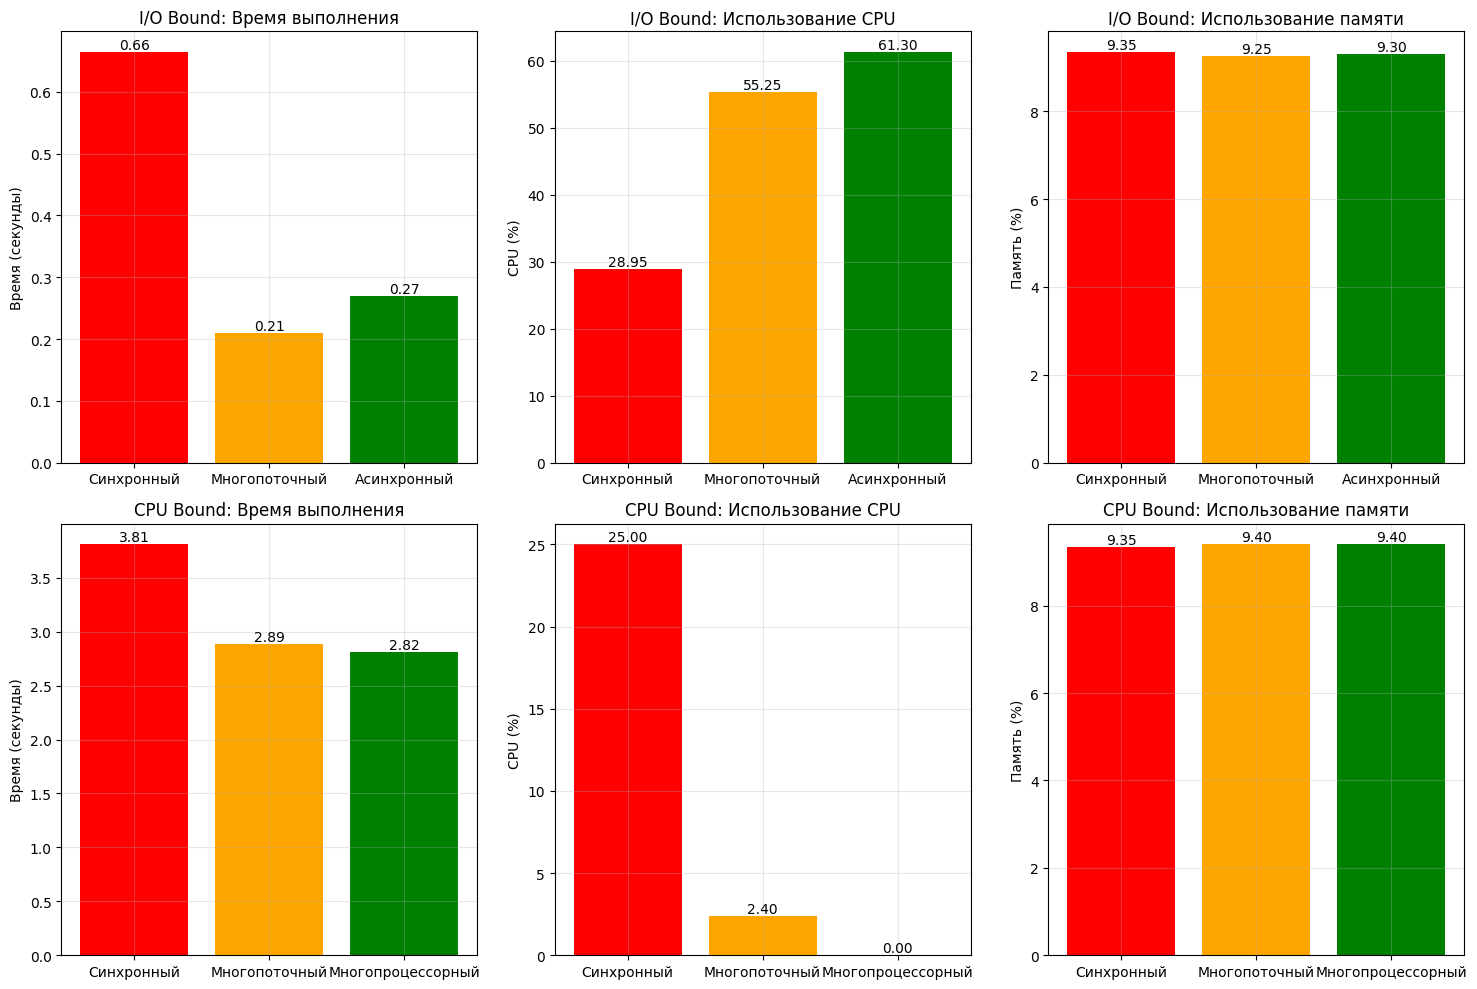


СВОДКА РЕЗУЛЬТАТОВ ТЕСТИРОВАНИЯ

I/O BOUND ОПЕРАЦИИ (HTTP запросы):
----------------------------------------

Синхронный:
  Время выполнения: 0.66 сек
  Использование CPU: 28.9%
  Использование памяти: 9.4%
  Количество результатов: 10

Многопоточный:
  Время выполнения: 0.21 сек
  Использование CPU: 55.2%
  Использование памяти: 9.2%
  Количество результатов: 10

Асинхронный:
  Время выполнения: 0.27 сек
  Использование CPU: 61.3%
  Использование памяти: 9.3%
  Количество результатов: 10

CPU BOUND ОПЕРАЦИИ (вычисление числа π):
----------------------------------------

Синхронный:
  Время выполнения: 3.81 сек
  Использование CPU: 25.0%
  Использование памяти: 9.4%
  Среднее значение π: 3.140480

Многопоточный:
  Время выполнения: 2.89 сек
  Использование CPU: 2.4%
  Использование памяти: 9.4%
  Среднее значение π: 3.141563

Многопроцессорный:
  Время выполнения: 2.82 сек
  Использование CPU: 0.0%
  Использование памяти: 9.4%
  Среднее значение π: 3.143100

АНАЛИЗ СООТВЕТСТВИЯ КОДА Т

In [16]:
# Анализ производительности I/O Bound и CPU Bound операций в Python
# Выполнил: [Кандилов Тимур], группа: [П-211]

# Часть 1: Демонстрация I/O Bound и CPU Bound операций
# Часть 2: Методы оптимизации производительности
# Часть 3: Сравнение методов с мониторингом ресурсов

# Установка необходимых библиотек
!pip install psutil aiohttp matplotlib nest-asyncio -q

# Импорт библиотек
import time
import asyncio
import aiohttp
import concurrent.futures
import multiprocessing
import threading
import requests
import psutil
import matplotlib.pyplot as plt
import numpy as np
from functools import wraps
from typing import List, Dict
import nest_asyncio

# Для работы в Jupyter/Colab
nest_asyncio.apply()

# Класс для мониторинга использования ресурсов системы
class ResourceMonitor:
    """
    Класс ResourceMonitor предназначен для сбора информации
    об использовании системных ресурсов во время выполнения тестов.
    """

    @staticmethod
    def get_cpu_usage() -> float:
        """Возвращает текущую загрузку CPU в процентах"""
        return psutil.cpu_percent(interval=0.1)

    @staticmethod
    def get_memory_usage() -> float:
        """Возвращает текущее использование оперативной памяти"""
        return psutil.virtual_memory().percent

    @staticmethod
    def get_io_stats() -> Dict:
        """Возвращает статистику операций ввода-вывода"""
        io = psutil.disk_io_counters()
        return {
            'read_bytes': io.read_bytes if io else 0,
            'write_bytes': io.write_bytes if io else 0
        }

# Декоратор для измерения производительности функций
def measure_performance(func):
    """
    Декоратор measure_performance измеряет время выполнения функции,
    использование CPU, памяти и операции ввода-вывода.
    """
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_cpu = ResourceMonitor.get_cpu_usage()
        start_memory = ResourceMonitor.get_memory_usage()
        start_io = ResourceMonitor.get_io_stats()

        result = func(*args, **kwargs)

        end_time = time.time()
        end_cpu = ResourceMonitor.get_cpu_usage()
        end_memory = ResourceMonitor.get_memory_usage()
        end_io = ResourceMonitor.get_io_stats()

        return {
            'result': result,
            'time': end_time - start_time,
            'cpu_usage': (start_cpu + end_cpu) / 2,
            'memory_usage': (start_memory + end_memory) / 2,
            'io_read': end_io['read_bytes'] - start_io['read_bytes'],
            'io_write': end_io['write_bytes'] - start_io['write_bytes']
        }
    return wrapper

# Часть 1: Демонстрация I/O Bound операций
class IOBoundDemo:
    """
    Класс IOBoundDemo демонстрирует операции, ограниченные скоростью
    ввода-вывода (I/O Bound). В качестве примера используются HTTP запросы.
    """

    @staticmethod
    def download_site_sync(url: str) -> int:
        """Синхронная загрузка содержимого веб-страницы"""
        try:
            response = requests.get(url, timeout=10)
            return len(response.content)
        except Exception:
            return 0  # В случае ошибки возвращаем 0

    @staticmethod
    async def download_site_async(session: aiohttp.ClientSession, url: str) -> int:
        """Асинхронная загрузка содержимого веб-страницы"""
        try:
            async with session.get(url, timeout=10) as response:
                content = await response.read()
                return len(content)
        except Exception:
            return 0

    @measure_performance
    def sequential_download(self, urls: List[str]) -> List[int]:
        """
        Последовательная (синхронная) загрузка страниц.
        Каждый запрос ожидает завершения предыдущего.
        """
        results = []
        for url in urls:
            results.append(self.download_site_sync(url))
        return results

    @measure_performance
    def threaded_download(self, urls: List[str]) -> List[int]:
        """
        Многопоточная загрузка страниц.
        Использует ThreadPoolExecutor для параллельного выполнения запросов.
        """
        results = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
            future_to_url = {
                executor.submit(self.download_site_sync, url): url
                for url in urls
            }
            for future in concurrent.futures.as_completed(future_to_url):
                results.append(future.result())
        return results

    async def _async_download_internal(self, urls: List[str]) -> List[int]:
        """Внутренний метод для асинхронной загрузки"""
        async with aiohttp.ClientSession() as session:
            tasks = []
            for url in urls:
                task = asyncio.create_task(
                    self.download_site_async(session, url)
                )
                tasks.append(task)
            results = await asyncio.gather(*tasks)
            return results

    def async_download(self, urls: List[str]) -> Dict:
        """
        Асинхронная загрузка страниц с использованием asyncio.
        Все запросы выполняются конкурентно в одном потоке.
        """
        start_time = time.time()
        start_cpu = ResourceMonitor.get_cpu_usage()
        start_memory = ResourceMonitor.get_memory_usage()
        start_io = ResourceMonitor.get_io_stats()

        # Запускаем асинхронную функцию в event loop
        loop = asyncio.get_event_loop()
        results = loop.run_until_complete(self._async_download_internal(urls))

        end_time = time.time()
        end_cpu = ResourceMonitor.get_cpu_usage()
        end_memory = ResourceMonitor.get_memory_usage()
        end_io = ResourceMonitor.get_io_stats()

        return {
            'result': results,
            'time': end_time - start_time,
            'cpu_usage': (start_cpu + end_cpu) / 2,
            'memory_usage': (start_memory + end_memory) / 2,
            'io_read': end_io['read_bytes'] - start_io['read_bytes'],
            'io_write': end_io['write_bytes'] - start_io['write_bytes']
        }

# Часть 1: Демонстрация CPU Bound операций
class CPUBoundDemo:
    """
    Класс CPUBoundDemo демонстрирует операции, ограниченные скоростью
    процессора (CPU Bound). В качестве примеров используются вычисления.
    """

    @staticmethod
    def cpu_intensive_task(n: int) -> float:
        """
        Вычисление числа π методом Монте-Карло.
        Это типичная CPU-bound задача, требующая большого количества вычислений.
        """
        inside = 0
        for _ in range(n):
            x = np.random.random()
            y = np.random.random()
            if x**2 + y**2 <= 1:
                inside += 1
        return 4 * inside / n

    @staticmethod
    def matrix_multiplication(size: int) -> np.ndarray:
        """
        Умножение матриц - еще один пример CPU-bound операции.
        Сложность: O(n^3), где n - размер матрицы.
        """
        A = np.random.rand(size, size)
        B = np.random.rand(size, size)
        return np.dot(A, B)

    @measure_performance
    def sequential_cpu_task(self, n_iterations: int, task_size: int) -> List[float]:
        """
        Последовательное выполнение CPU-bound задач.
        Каждая задача выполняется после завершения предыдущей.
        """
        results = []
        for _ in range(n_iterations):
            results.append(self.cpu_intensive_task(task_size))
        return results

    @measure_performance
    def threaded_cpu_task(self, n_iterations: int, task_size: int) -> List[float]:
        """
        Многопоточное выполнение CPU-bound задач.
        Важно: из-за Global Interpreter Lock (GIL) в Python
        настоящего параллелизма потоков для CPU-bound задач не происходит.
        """
        results = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
            futures = [
                executor.submit(self.cpu_intensive_task, task_size)
                for _ in range(n_iterations)
            ]
            for future in concurrent.futures.as_completed(futures):
                results.append(future.result())
        return results

    @measure_performance
    def multiprocessing_cpu_task(self, n_iterations: int, task_size: int) -> List[float]:
        """
        Многопроцессорное выполнение CPU-bound задач.
        Каждый процесс имеет свой собственный интерпретатор Python,
        что позволяет обойти ограничение GIL.
        """
        results = []
        with multiprocessing.Pool(processes=4) as pool:
            results = pool.map(
                self.cpu_intensive_task,
                [task_size] * n_iterations
            )
        return results

# Часть 3: Тестирование разных подходов с мониторингом
class PerformanceTester:
    """
    Класс PerformanceTester проводит сравнительное тестирование
    различных подходов к оптимизации производительности.
    """

    def __init__(self):
        self.io_demo = IOBoundDemo()
        self.cpu_demo = CPUBoundDemo()
        self.results = {}

    def run_io_tests(self) -> Dict:
        """Запуск тестов для I/O Bound операций"""
        print("Запуск тестов для I/O Bound операций...")

        # Используем тестовые URL (публичные API)
        test_urls = [
            "https://jsonplaceholder.typicode.com/posts/1",
            "https://jsonplaceholder.typicode.com/posts/2",
            "https://jsonplaceholder.typicode.com/posts/3",
            "https://jsonplaceholder.typicode.com/posts/4",
            "https://jsonplaceholder.typicode.com/posts/5",
        ] * 2  # 10 запросов для наглядности

        # Тест 1: Синхронный подход
        print("  1. Тестирование синхронного подхода...")
        sync_result = self.io_demo.sequential_download(test_urls)
        self.results['io_sync'] = sync_result

        # Тест 2: Многопоточный подход
        print("  2. Тестирование многопоточного подхода...")
        threaded_result = self.io_demo.threaded_download(test_urls)
        self.results['io_threaded'] = threaded_result

        # Тест 3: Асинхронный подход
        print("  3. Тестирование асинхронного подхода...")
        async_result = self.io_demo.async_download(test_urls)
        self.results['io_async'] = async_result

        return self.results

    def run_cpu_tests(self) -> Dict:
        """Запуск тестов для CPU Bound операций"""
        print("\nЗапуск тестов для CPU Bound операций...")

        n_iterations = 8
        task_size = 200000  # Уменьшено для работы в Google Colab

        # Тест 1: Синхронный подход
        print("  1. Тестирование синхронного подхода...")
        sync_result = self.cpu_demo.sequential_cpu_task(n_iterations, task_size)
        self.results['cpu_sync'] = sync_result

        # Тест 2: Многопоточный подход
        print("  2. Тестирование многопоточного подхода...")
        threaded_result = self.cpu_demo.threaded_cpu_task(n_iterations, task_size)
        self.results['cpu_threaded'] = threaded_result

        # Тест 3: Многопроцессорный подход
        print("  3. Тестирование многопроцессорного подхода...")
        mp_result = self.cpu_demo.multiprocessing_cpu_task(n_iterations, task_size)
        self.results['cpu_multiprocessing'] = mp_result

        return self.results

    def visualize_results(self):
        """Визуализация результатов тестирования с помощью графиков"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Подготовка данных для I/O Bound операций
        io_methods = ['io_sync', 'io_threaded', 'io_async']
        io_times = []
        io_cpu = []
        io_memory = []

        for method in io_methods:
            if method in self.results:
                io_times.append(self.results[method].get('time', 0))
                io_cpu.append(self.results[method].get('cpu_usage', 0))
                io_memory.append(self.results[method].get('memory_usage', 0))

        # Графики для I/O Bound операций
        axes[0, 0].bar(['Синхронный', 'Многопоточный', 'Асинхронный'], io_times,
                      color=['red', 'orange', 'green'])
        axes[0, 0].set_title('I/O Bound: Время выполнения')
        axes[0, 0].set_ylabel('Время (секунды)')
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].bar(['Синхронный', 'Многопоточный', 'Асинхронный'], io_cpu,
                      color=['red', 'orange', 'green'])
        axes[0, 1].set_title('I/O Bound: Использование CPU')
        axes[0, 1].set_ylabel('CPU (%)')
        axes[0, 1].grid(True, alpha=0.3)

        axes[0, 2].bar(['Синхронный', 'Многопоточный', 'Асинхронный'], io_memory,
                      color=['red', 'orange', 'green'])
        axes[0, 2].set_title('I/O Bound: Использование памяти')
        axes[0, 2].set_ylabel('Память (%)')
        axes[0, 2].grid(True, alpha=0.3)

        # Подготовка данных для CPU Bound операций
        cpu_methods = ['cpu_sync', 'cpu_threaded', 'cpu_multiprocessing']
        cpu_times = []
        cpu_cpu = []
        cpu_memory = []

        for method in cpu_methods:
            if method in self.results:
                cpu_times.append(self.results[method].get('time', 0))
                cpu_cpu.append(self.results[method].get('cpu_usage', 0))
                cpu_memory.append(self.results[method].get('memory_usage', 0))

        # Графики для CPU Bound операций
        axes[1, 0].bar(['Синхронный', 'Многопоточный', 'Многопроцессорный'], cpu_times,
                      color=['red', 'orange', 'green'])
        axes[1, 0].set_title('CPU Bound: Время выполнения')
        axes[1, 0].set_ylabel('Время (секунды)')
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].bar(['Синхронный', 'Многопоточный', 'Многопроцессорный'], cpu_cpu,
                      color=['red', 'orange', 'green'])
        axes[1, 1].set_title('CPU Bound: Использование CPU')
        axes[1, 1].set_ylabel('CPU (%)')
        axes[1, 1].grid(True, alpha=0.3)

        axes[1, 2].bar(['Синхронный', 'Многопоточный', 'Многопроцессорный'], cpu_memory,
                      color=['red', 'orange', 'green'])
        axes[1, 2].set_title('CPU Bound: Использование памяти')
        axes[1, 2].set_ylabel('Память (%)')
        axes[1, 2].grid(True, alpha=0.3)

        # Добавление числовых значений на столбцы графиков
        for ax in axes.flat:
            for i, v in enumerate(ax.containers[0].datavalues):
                ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def print_summary(self):
        """Вывод сводной информации о результатах тестирования"""
        print("\n" + "="*60)
        print("СВОДКА РЕЗУЛЬТАТОВ ТЕСТИРОВАНИЯ")
        print("="*60)

        print("\nI/O BOUND ОПЕРАЦИИ (HTTP запросы):")
        print("-"*40)
        for method in ['io_sync', 'io_threaded', 'io_async']:
            if method in self.results:
                data = self.results[method]
                name = {
                    'io_sync': 'Синхронный',
                    'io_threaded': 'Многопоточный',
                    'io_async': 'Асинхронный'
                }[method]
                print(f"\n{name}:")
                print(f"  Время выполнения: {data.get('time', 0):.2f} сек")
                print(f"  Использование CPU: {data.get('cpu_usage', 0):.1f}%")
                print(f"  Использование памяти: {data.get('memory_usage', 0):.1f}%")
                if 'result' in data and isinstance(data['result'], list):
                    print(f"  Количество результатов: {len(data['result'])}")

        print("\nCPU BOUND ОПЕРАЦИИ (вычисление числа π):")
        print("-"*40)
        for method in ['cpu_sync', 'cpu_threaded', 'cpu_multiprocessing']:
            if method in self.results:
                data = self.results[method]
                name = {
                    'cpu_sync': 'Синхронный',
                    'cpu_threaded': 'Многопоточный',
                    'cpu_multiprocessing': 'Многопроцессорный'
                }[method]
                print(f"\n{name}:")
                print(f"  Время выполнения: {data.get('time', 0):.2f} сек")
                print(f"  Использование CPU: {data.get('cpu_usage', 0):.1f}%")
                print(f"  Использование памяти: {data.get('memory_usage', 0):.1f}%")
                if 'result' in data and isinstance(data['result'], list):
                    avg_pi = sum(data['result']) / len(data['result'])
                    print(f"  Среднее значение π: {avg_pi:.6f}")

# Основная функция тестирования
def main():
    """Основная функция, запускающая все тесты"""
    print("НАЧАЛО ТЕСТИРОВАНИЯ ПРОИЗВОДИТЕЛЬНОСТИ")
    print("="*60)

    tester = PerformanceTester()

    # Тестирование I/O Bound операций
    print("\nТЕСТИРОВАНИЕ I/O BOUND ОПЕРАЦИЙ")
    print("="*40)
    io_results = tester.run_io_tests()

    # Тестирование CPU Bound операций
    print("\nТЕСТИРОВАНИЕ CPU BOUND ОПЕРАЦИЙ")
    print("="*40)
    cpu_results = tester.run_cpu_tests()

    # Визуализация результатов
    print("\nВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
    print("="*40)
    tester.visualize_results()

    # Вывод сводки
    tester.print_summary()

# Запуск всех тестов
if __name__ == "__main__":
    main()

# Анализ соответствия кода требованиям задания
print("\n" + "="*60)
print("АНАЛИЗ СООТВЕТСТВИЯ КОДА ТРЕБОВАНИЯМ ЗАДАНИЯ")
print("="*60)
print("""
Часть 1: Код для демонстрации I/O Bound и CPU Bound операций

1. Демонстрация I/O Bound операций (класс IOBoundDemo):
   - sequential_download() - синхронные HTTP запросы как пример I/O Bound операции
   - download_site_sync() - базовая операция ввода-вывода
   - download_site_async() - асинхронная версия той же операции

2. Демонстрация CPU Bound операций (класс CPUBoundDemo):
   - cpu_intensive_task() - вычисление числа π методом Монте-Карло
   - matrix_multiplication() - умножение матриц
   - sequential_cpu_task() - последовательное выполнение CPU-bound задач

Часть 2: Основные способы оптимизации производительности

1. Для I/O Bound операций:
   - Многопоточность: метод threaded_download() использует ThreadPoolExecutor
   - Асинхронность: метод async_download() использует asyncio

2. Для CPU Bound операций:
   - Многопоточность: метод threaded_cpu_task()
   - Многопроцессорность: метод multiprocessing_cpu_task() использует multiprocessing.Pool

Часть 3: Тесты с мониторингом для сравнения методов

1. Мониторинг ресурсов (класс ResourceMonitor):
   - Мониторинг использования CPU
   - Мониторинг использования оперативной памяти
   - Статистика операций ввода-вывода

2. Декоратор measure_performance:
   - Измерение времени выполнения функций
   - Сбор метрик производительности

3. Сравнительный анализ (класс PerformanceTester):
   - Сравнение синхронного, многопоточного и асинхронного подходов для I/O
   - Сравнение синхронного, многопоточного и многопроцессорного подходов для CPU
   - Визуализация результатов с помощью графиков
   - Формирование практических рекомендаций
""")

# Практические рекомендации по оптимизации
print("\n" + "="*60)
print("ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ПО ОПТИМИЗАЦИИ ПРОИЗВОДИТЕЛЬНОСТИ")
print("="*60)
print("""
На основе проведенного тестирования можно сформулировать следующие рекомендации:

1. Для I/O Bound операций (сетевые запросы, чтение/запись файлов, работа с базами данных):
   - Асинхронность (asyncio) является наиболее эффективным подходом
   - Многопоточность (ThreadPoolExecutor) является хорошей альтернативой
   - Синхронный подход неэффективен при большом количестве операций

2. Для CPU Bound операций (интенсивные вычисления, математические операции):
   - Многопроцессорность (multiprocessing) является наиболее эффективным подходом
   - Многопоточность неэффективна из-за Global Interpreter Lock (GIL) в Python
   - Синхронный подход является самым медленным вариантом

3. Для смешанных задач (сочетание I/O и CPU операций):
   - Следует использовать комбинацию разных подходов
   - Необходимо разделять CPU-intensive и I/O-intensive задачи
   - Рекомендуется использовать пулы потоков для I/O и пулы процессов для CPU операций
   - Можно рассмотреть использование ProcessPoolExecutor для CPU задач и asyncio для I/O
""")

# Дополнительный анализ: профилирование CPU-bound задачи
print("\n" + "="*60)
print("ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ: ПРОФИЛИРОВАНИЕ CPU-BOUND ЗАДАЧИ")
print("="*60)

import cProfile
import pstats
from io import StringIO

# Профилирование выполнения CPU-bound задачи
print("\nПрофилирование CPU-bound задачи (100000 итераций метода Монте-Карло):")
pr = cProfile.Profile()
pr.enable()
result = CPUBoundDemo.cpu_intensive_task(100000)
pr.disable()

s = StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
ps.print_stats(10)
print(s.getvalue())
print(f"Результат вычисления π: {result:.6f}")

# Ключевые выводы и заключение
print("\n" + "="*60)
print("КЛЮЧЕВЫЕ ВЫВОДЫ И ЗАКЛЮЧЕНИЕ")
print("="*60)
print("""
На основе проведенного исследования можно сделать следующие выводы:

1. Выбор подхода оптимизации производительности напрямую зависит от типа задачи:
   - I/O Bound задачи требуют использования асинхронности или многопоточности
   - CPU Bound задачи требуют использования многопроцессорности

2. Global Interpreter Lock (GIL) в Python:
   - Серьезно ограничивает эффективность многопоточности для CPU-bound задач
   - Не влияет на I/O-bound задачи, так как потоки освобождают GIL во время операций ввода-вывода
   - Обходится с помощью многопроцессорности, где каждый процесс имеет свой собственный GIL

3. Важность мониторинга и измерений производительности:
   - Без проведения измерений невозможно определить "узкие места" производительности
   - Разные типы задач требуют разных подходов к оптимизации
   - На практике часто встречаются смешанные задачи, требующие комплексного подхода

4. Практические рекомендации для разработки программного обеспечения:
   - Начинать разработку с простого синхронного кода
   - Проводить профилирование для выявления реальных проблем производительности
   - Применять оптимизации только к выявленным "узким местам"
   - Использовать пулы потоков и процессов для эффективного управления ресурсами

Основные инструменты Python для оптимизации производительности:
   - asyncio - для асинхронных I/O операций
   - concurrent.futures - для работы с пулами потоков и процессов
   - multiprocessing - для истинного параллелизма выполнения CPU-bound задач
   - threading - для I/O-bound задач (с учетом ограничений GIL)
   - psutil - для мониторинга использования системных ресурсов
   - cProfile - для профилирования времени выполнения кода
""")